In [1]:
#IMPORTING

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import os
import math
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense
import keras_tuner as kt
from sklearn.model_selection import train_test_split


Loading Data

In [2]:
train_images_path = Path("../input/car-object-detection/data/training_images")
test_images_path = Path("../input/car-object-detection/data/testing_images")

Preprocessing

In [10]:
train = pd.read_csv("../input/car-object-detection/data/train_solution_bounding_boxes (1).csv")
print(train)
train[['xmin', 'ymin', 'xmax', 'ymax']] = train[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
train = train.groupby('image')[['xmin', 'ymin', 'xmax', 'ymax']].apply(lambda x: x.values.flatten().tolist()).reset_index()


               image        xmin        ymin        xmax        ymax
0     vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1    vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2    vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3    vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4    vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422
..               ...         ...         ...         ...         ...
554   vid_4_9860.jpg    0.000000  198.321729   49.235251  236.223284
555   vid_4_9880.jpg  329.876184  156.482351  536.664239  250.497895
556   vid_4_9900.jpg    0.000000  168.295823  141.797524  239.176652
557   vid_4_9960.jpg  487.428988  172.233646  616.917699  228.839864
558   vid_4_9980.jpg  221.558631  182.570434  348.585579  238.192196

[559 rows x 5 columns]


In [11]:
print(train)

               image                     0
0     vid_4_1000.jpg  [281, 187, 327, 223]
1    vid_4_10000.jpg   [15, 187, 120, 236]
2    vid_4_10020.jpg  [496, 172, 630, 231]
3    vid_4_10040.jpg  [239, 176, 361, 236]
4    vid_4_10060.jpg   [16, 186, 132, 238]
..               ...                   ...
350   vid_4_9860.jpg     [0, 198, 49, 236]
351   vid_4_9880.jpg  [329, 156, 536, 250]
352   vid_4_9900.jpg    [0, 168, 141, 239]
353   vid_4_9960.jpg  [487, 172, 616, 228]
354   vid_4_9980.jpg  [221, 182, 348, 238]

[355 rows x 2 columns]


In [12]:
train.columns = ['image_name','coordinates']
max_length = train['coordinates'].str.len().max()
#padding
train['coordinates'] = train['coordinates'].apply(lambda x: x + [0] * (max_length - len(x)))


In [13]:
print(train)

          image_name                                        coordinates
0     vid_4_1000.jpg  [281, 187, 327, 223, 0, 0, 0, 0, 0, 0, 0, 0, 0...
1    vid_4_10000.jpg  [15, 187, 120, 236, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2    vid_4_10020.jpg  [496, 172, 630, 231, 0, 0, 0, 0, 0, 0, 0, 0, 0...
3    vid_4_10040.jpg  [239, 176, 361, 236, 0, 0, 0, 0, 0, 0, 0, 0, 0...
4    vid_4_10060.jpg  [16, 186, 132, 238, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
..               ...                                                ...
350   vid_4_9860.jpg  [0, 198, 49, 236, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
351   vid_4_9880.jpg  [329, 156, 536, 250, 0, 0, 0, 0, 0, 0, 0, 0, 0...
352   vid_4_9900.jpg  [0, 168, 141, 239, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
353   vid_4_9960.jpg  [487, 172, 616, 228, 0, 0, 0, 0, 0, 0, 0, 0, 0...
354   vid_4_9980.jpg  [221, 182, 348, 238, 0, 0, 0, 0, 0, 0, 0, 0, 0...

[355 rows x 2 columns]


In [14]:
test_images = []
for filename in os.listdir(test_images_path):
    img_path = os.path.join(test_images_path, filename)
    image = cv2.imread(img_path) / 255.
    test_images.append(image)

DISPLAY FUNCTIONS->

In [15]:
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    # if the image has been normalized, scale it up
    if norm:
        img *= 255.
        img = img.astype(np.uint8)
    
    # Draw the bounding boxes
    while len(bbox_coords) > 0:
        xmin, ymin, xmax, ymax = bbox_coords[:4]
        bbox_coords = bbox_coords[4:]
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)
        
    while len(pred_coords) > 0:
        xmin, ymin, xmax, ymax = pred_coords[:4]
        pred_coords = pred_coords[4:]
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)
    
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
def display_image_from_file(name, bbox_coords=[], path=train_images_path):
    img = cv2.imread(str(path/name))
    display_image(img, bbox_coords=bbox_coords)
    
def display_from_dataframe(row, path=train_images_path):
    display_image_from_file(row['image_name'], bbox_coords=row.coordinates, path=path)
    
def display_grid(df=train, n_items=3):
    plt.figure(figsize=(20, 10))
    
    # get 3 random entries and plot them in a 1x3 grid
    rand_indices = [np.random.randint(0, df.shape[0]) for _ in range(n_items)]
    
    for pos, index in enumerate(rand_indices):
        plt.subplot(1, n_items, pos + 1)
        display_from_dataframe(df.loc[index, :])

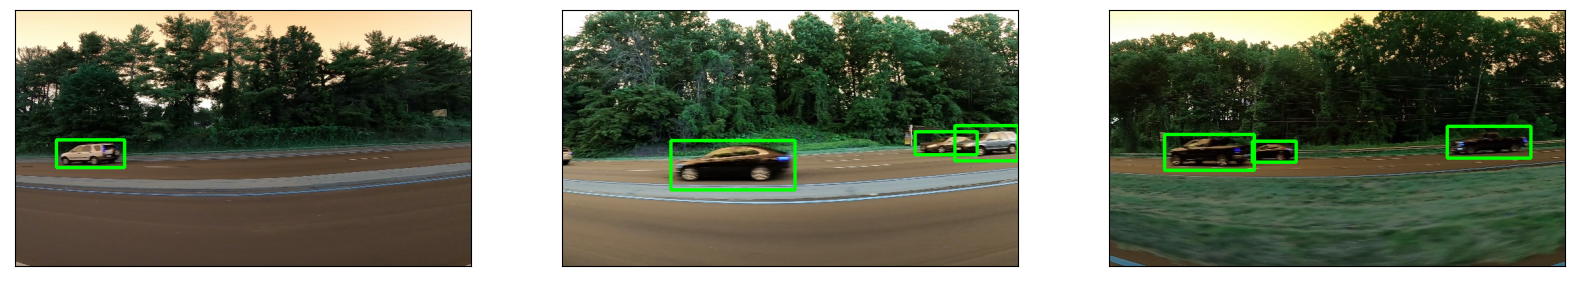

In [16]:
display_grid()

YAYYYYYYYYY!!! IT WORKED!

Model Training

In [18]:
def data_generator(df=train, batch_size=16, path=train_images_path):
    while True:        
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_box_coords = np.zeros((batch_size, max_length))
        
        for i in range(batch_size):
                rand_index = np.random.randint(0, train.shape[0])
                row = df.loc[rand_index, :]
                images[i] = cv2.imread(str(path/row.image_name)) / 255.
                bounding_box_coords[i] = np.array(row.coordinates)
                
        yield {'image': images}, {'coords': bounding_box_coords}

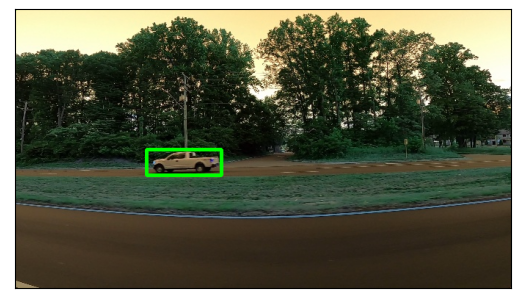

In [19]:
#TESTING

example, label = next(data_generator(batch_size=1))
img = example['image'][0]
bbox_coords = label['coords'][0]

display_image(img, bbox_coords=bbox_coords, norm=True)

Model Building

In [22]:
def model_builder(hp):
    # Initialize the sequiential model
    model = tf.keras.Sequential()
    model.add(Input(shape=[380, 676, 3], name='image'))
    # Define the number of convolutional layers to use and were the powers start   
    hp_convolutional_layers = hp.Int('convolutional_layers', min_value=6, max_value=12, step=2)
    hp_power_filter = hp.Int('first_power_filter', min_value=3, max_value=5, step=1)
    for i in range(hp_convolutional_layers):
        model.add(Conv2D(2**hp_power_filter, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(2, padding='same'))
        hp_power_filter = min(10,hp_power_filter + 1)

    # Añadir las capas de aplanado y las capas deansas y de salida
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(max_length, activation='relu', name='coords'))

    # Compilamos el modelo
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
                  loss='mse',
                  metrics=['accuracy'])
    
    return model

testing model functions->

In [24]:
def test_model(model, datagen):
    example, label = next(datagen)
    
    X = example['image']
    y = label['coords']
    
    pred_bbox = model.predict(X)[0]
    
    img = X[0]
    gt_coords = y[0]
    
    display_image(img, bbox_coords=gt_coords, pred_coords=pred_bbox, norm=True)

    
    
def test(model):
    datagen = data_generator(batch_size=1)
    
    plt.figure(figsize=(15,7))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        test_model(model, datagen)    
    plt.show()
    
    
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

tuner = kt.Hyperband(model_builder,
                     objective='accuracy',
                     max_epochs=5,
                     factor=3)
with tf.device('/GPU:0'):
    tuner.search(data_generator(), epochs=5, steps_per_epoch = 500, callbacks=[early_stopping,ShowTestImages()])
    
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Number of convilutional layers: {best_hps.get("convolutional_layers")}')
print(f'Filters in the first covolutional layer: {2**best_hps.get("first_power_filter")}')

Trial 10 Complete [00h 12m 25s]
accuracy: 0.9465000033378601

Best accuracy So Far: 0.9465000033378601
Total elapsed time: 01h 16m 22s
Number of convilutional layers: 8
Filters in the first covolutional layer: 32


In [30]:
#now we build using best possible hyperparameters

model = tuner.hypermodel.build(best_hps)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 380, 676, 32)      896       
                                                                 
 batch_normalization_32 (Bat  (None, 380, 676, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 190, 338, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 190, 338, 64)      18496     
                                                                 
 batch_normalization_33 (Bat  (None, 190, 338, 64)     256       
 chNormalization)                                                
                                                      

Training!

Epoch 1/15
1/1 [==============================] - 0s 22ms/step


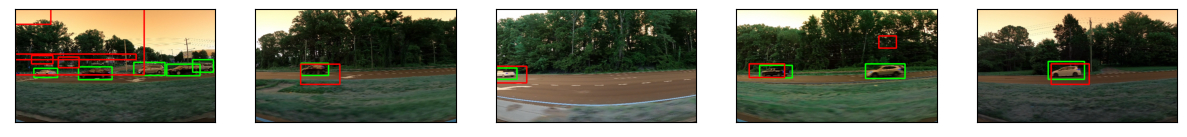

500/500 [==============================] - 143s 276ms/step - loss: 7197.9888 - accuracy: 0.6880
Epoch 2/15
1/1 [==============================] - 0s 25ms/step


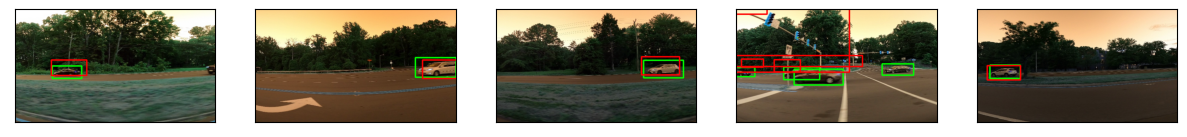

500/500 [==============================] - 138s 276ms/step - loss: 2976.7129 - accuracy: 0.8879
Epoch 3/15
1/1 [==============================] - 0s 24ms/step


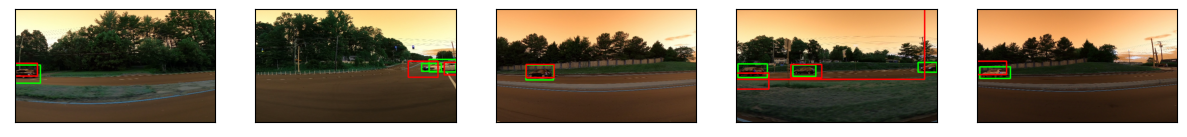

500/500 [==============================] - 137s 274ms/step - loss: 2614.5874 - accuracy: 0.9172
Epoch 4/15
1/1 [==============================] - 0s 24ms/step


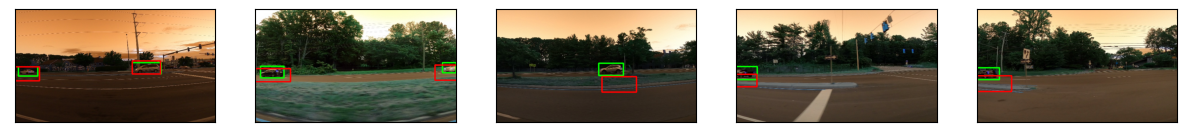

500/500 [==============================] - 136s 272ms/step - loss: 2599.7673 - accuracy: 0.9271
Epoch 5/15
1/1 [==============================] - 0s 25ms/step


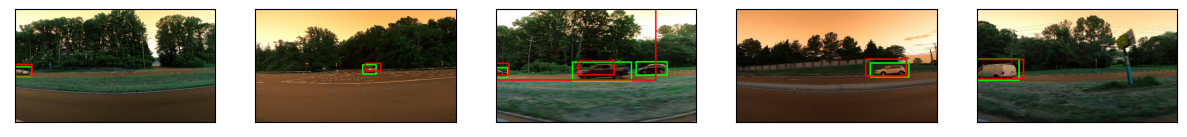

500/500 [==============================] - 136s 272ms/step - loss: 1800.0737 - accuracy: 0.9651
Epoch 6/15
1/1 [==============================] - 0s 24ms/step


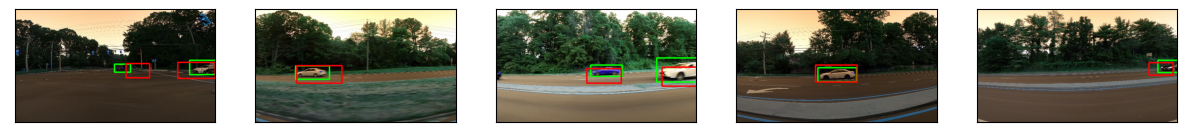

500/500 [==============================] - 139s 278ms/step - loss: 2297.8013 - accuracy: 0.9200
Epoch 7/15
1/1 [==============================] - 0s 25ms/step


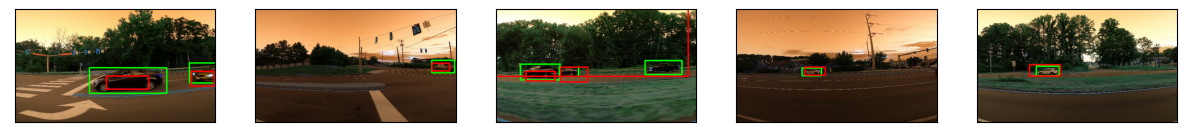

500/500 [==============================] - 138s 276ms/step - loss: 1817.8604 - accuracy: 0.9585
Epoch 8/15
1/1 [==============================] - 0s 24ms/step


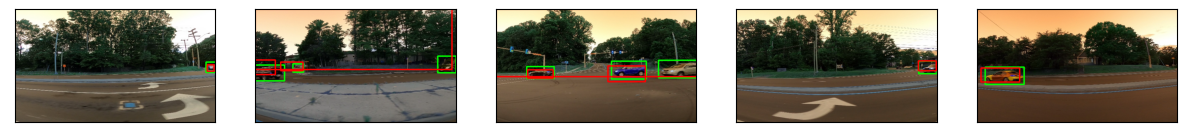

500/500 [==============================] - 137s 275ms/step - loss: 1697.9427 - accuracy: 0.9674
Epoch 9/15
1/1 [==============================] - 0s 23ms/step


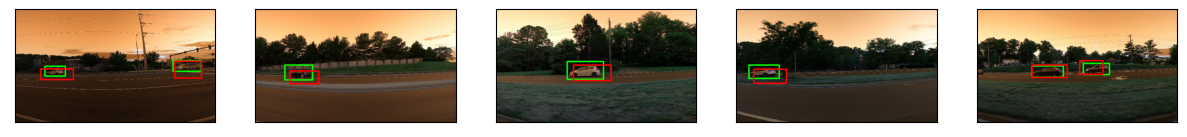

500/500 [==============================] - 137s 274ms/step - loss: 1311.6031 - accuracy: 0.9659
Epoch 10/15
1/1 [==============================] - 0s 25ms/step


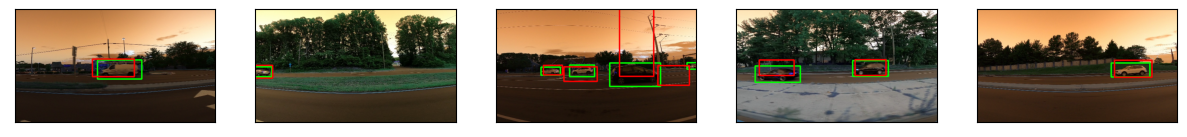

500/500 [==============================] - 137s 274ms/step - loss: 752.5580 - accuracy: 0.9716
Epoch 11/15
1/1 [==============================] - 0s 22ms/step


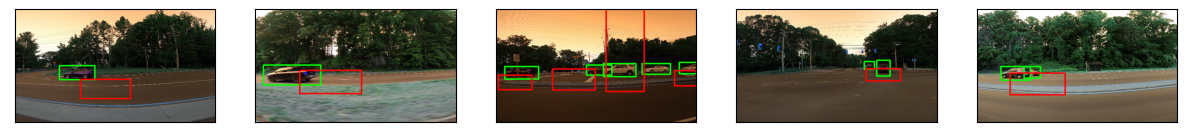

500/500 [==============================] - 136s 272ms/step - loss: 1125.5609 - accuracy: 0.9482
Epoch 12/15
1/1 [==============================] - 0s 24ms/step


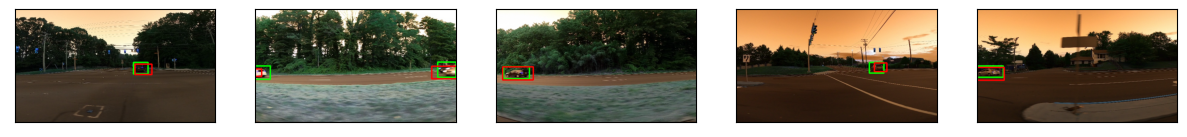

500/500 [==============================] - 137s 273ms/step - loss: 1218.7489 - accuracy: 0.9406
Epoch 13/15
1/1 [==============================] - 0s 23ms/step


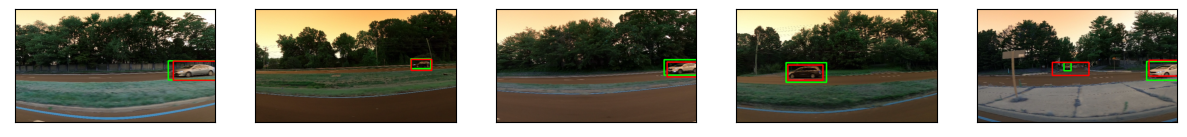

500/500 [==============================] - 135s 271ms/step - loss: 821.2419 - accuracy: 0.9651
Epoch 14/15
1/1 [==============================] - 0s 21ms/step


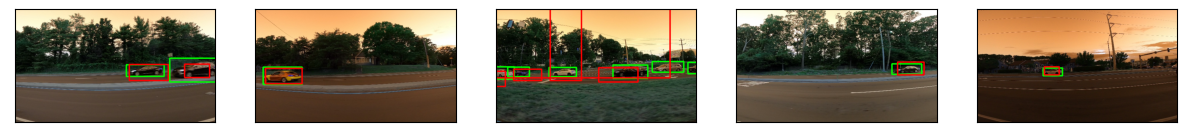

500/500 [==============================] - 134s 269ms/step - loss: 835.8415 - accuracy: 0.9711
Epoch 15/15
1/1 [==============================] - 0s 38ms/step


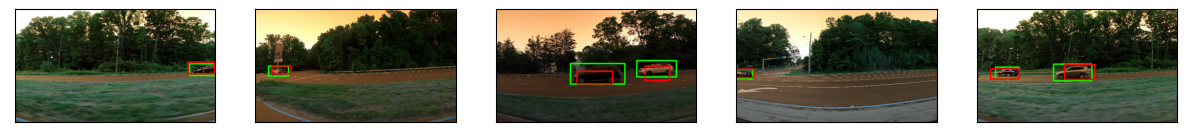

500/500 [==============================] - 134s 269ms/step - loss: 782.4133 - accuracy: 0.9697


In [31]:
with tf.device('/GPU:0'):
    _= model.fit(data_generator(), epochs=15, steps_per_epoch=500, callbacks=[ShowTestImages()])

RESULTS!+SAVING

In [33]:
model.save('car-object-detection.h5')